In [1]:
import os
# import pandas as pd
from pathlib import Path
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
from typing import List, Dict


datapath = Path('/home/jseia/Desktop/thesis/data/')
csv_path = Path('/home/jseia/Desktop/thesis/code/stroke-seg/data/dataset.csv')
base_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2')
os.environ['nnUNet_raw'] = str(base_path/'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = str(base_path/'preprocessed')
os.environ['nnUNet_results'] = str(base_path/'nnUNet_trained_models')

# # from ssl.model_interpreter import EmpeddingProjector, DimReductor, AttrGenerator
# # import sys ; sys.path.insert(0, '/home/jseia/Desktop/thesis/code/nnUNet_ais')
# import nnunetv2.ssl.plots as ssl_plots

# import sys ; sys.path.insert(0, '/home/jseia/Desktop/thesis/code/stroke-seg')
# from dataset.dataset import StrokeDataset
# import sys ; sys.path.remove('/home/jseia/Desktop/thesis/code/stroke-seg')

# dataset = StrokeDataset(
#     datapath=datapath,
#     datasets=['apis', 'aisd', 'tum'],#, 'tbi'], 
#     data_csv_path=csv_path,
#     cases_to_exclude=[],
#     pathology=['ais'],
#     modalities=['ncct', 'ncct-tilt', 'msk', 'msk-tilt'],
#     partitions=['train'],
#     standard=['gold', 'silver', '-'],
#     filter_discard=True
# )

In [18]:
import cv2
import json
import yaml

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import SimpleITK as sitk

from pathlib import Path
from scipy.spatial import KDTree
from typing import List, Dict, Tuple
from scipy.ndimage import correlate

from nnunetv2.paths import nnUNet_preprocessed, nnUNet_raw

PALETTE_DS = {"APIS": "C1", "AISD": "C2", 'icoAIS': "C0", 'C-TBI': "C3"}

def adapt_size(img: np.ndarray, destiny_shape: tuple,
               padd_val: int = None) -> np.ndarray:
    """Adapts the size of a 2d image, either padding or cropping
    independently in each of its dimensions.
    Args:
        img (np.ndarray): 2d image to adapt
        destiny_shape (tuple): Desired shape of the image
        padd_val (int, optional): value to use in padding.
            Defaults to None which means minimum value in the
            slice is used as padding value.
    Returns:
        np.ndarray: adjusted image
    """
    # if image is ok avoid processing
    if img.shape == destiny_shape:
        return img
    # for each dimension
    for i in range(len(img.shape)):
        diff = img.shape[i] - destiny_shape[i]
        half = diff // 2
        other_half = diff - half
        # crop using the middle portion
        if diff > 0:
            if i == 0:
                img = img[half:img.shape[0]-other_half, :]
            else:
                img = img[:, half:img.shape[1]-other_half]
        # padd leaving in the center
        elif diff < 0:
            half, other_half = np.abs(half), np.abs(other_half)
            padd = ((half, other_half), (0, 0))
            padd = padd if (i == 0) else (padd[1], padd[0])
            if padd_val is None:
                img = np.pad(img, padd, 'minimum')
            else:
                img = np.pad(img, padd, constant_values=padd_val)
    return img


def visualize_neighbours(base_exp_path: Path, base_cfg_path: Path, exp_cfg: Dict,
                         projections: pd.DataFrame, gt_path: Path, feat_prefix: str,
                         k: int = 6, preproc: bool = False, 
                         img_types: List = ['ncct', 'diff', 'attr', 'attr-diff', 'gt'],
                         slice_criteria: str = 'middle') -> Tuple[np.ndarray]:
    """Given a set of projections and a set of centers, get the  closest points to each of
    the centers. Then get the images from those examples and merge them in a single figure
    using the middle slice of the volume.
    Args:
        base_exp_path (Path): The base path where all SSL experiments are stored.
        base_cfg_path (Path): The base path where all the SSL cfg files are stored.
        exp_cfg (Dict): Dictionary containing all the experiment configurations.
            Neccesary keys:
                ['data', 'exp', 'context', 'centers':{'tsne', 'pca', 'umap}]
        projections (pd.DataFrame): Data frame containing the dimensionality reductions
            of the embeddings.
        gt_path (Path): Path where the ground truth images are stored
        feat_prefix (str): The prefix to identify the dim reduction method in the
            projections dataframe columns.
        k (int, optional): Number of nearest neighbours around the centers to retrieve.
            Defaults to 6.
        preproc (bool, optional): Whether to use the preprocessed image or the 
            raw nifties. Defaults to False.
        img_types (List, optional): _description_. Defaults to ['ncct', 'diff', 'attr', 'attr-diff', 'gt'].
        slice_criteria (str, optional): _description_. Defaults to 'middle'.

    Returns:
        Tuple[np.ndarray]: _description_
    """
    # Get the centers from the configuration dictionary
    centers = exp_cfg['centers'][feat_prefix]
    
    # Get the SSL configuration path and load it
    exp_path = base_cfg_path / exp_cfg['data']
    attr_path = base_exp_path / exp_cfg['data'] / exp_cfg["exp"] / 'attribution'
    cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
    with open(exp_path/cfg_filename, 'r') as yfile:
        cfg = yaml.safe_load(yfile)['training']
    
    # Reconstruct the preprocessing, raw and gt paths
    pp_path = Path(nnUNet_preprocessed) / cfg['dataset']
    dataset_fgpt = pp_path / 'nnUNetPlansSSL.json'
    pp_path = pp_path / f'{cfg["exp_planner"]}_{cfg["configuration"]}'
    raw_path = Path(nnUNet_raw) / cfg['dataset'] / f'imagesTr'
    
    # From the dataset fingerprint extract the median shape of the volumes
    with open(dataset_fgpt, 'r') as jfile:
        dataset_fgpt = json.load(jfile)
    destiny_shape = dataset_fgpt['original_median_shape_after_transp']

    # Generate the kdtree to get the k nearest neighbors to the centers
    projections.reset_index(drop=True, inplace=True)
    tree = KDTree(projections[[f'{feat_prefix}0', f'{feat_prefix}1']].values)
    _, indexes = tree.query(np.asarray(centers),  k=k)

    # Generate the collaged images for the different modalities
    # Instantiate the holder
    rows = {}
    for img_type in img_types:
        rows[img_type] = []

    # For each center get the images
    for pts_idxs in indexes:
        imgs = {}
        for img_type in img_types:
            imgs[img_type] = []
        for pt_idx in pts_idxs:
            subject = projections.iloc[pt_idx].subject

            # Get the ncct/gt/diff images acording to the different image files
            if preproc:
                filename = pp_path / f'{subject}.npy'
                ncct = np.load(filename)[0, ...]
                if 'diff' in img_types:
                    diff = np.load(filename)[1, ...]
            else:
                filename = raw_path / f'{subject}_0000.nii.gz'
                ncct = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))
                if 'diff' in img_types:
                    filename = raw_path / f'{subject}_0001.nii.gz'
                    diff = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))
            if 'gt' in img_types:
                filename = gt_path / f'{subject}.nii.gz'
                if not filename.exists():
                    gt = None
                else:
                    gt = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))

            if 'attr' in img_types:
                filename = attr_path / f'{subject}_saliency_ig.nii.gz'
                attr = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))
                if 'diff' in img_types:
                    filename = attr_path / f'{subject}_saliency_ig_diff.nii.gz'
                    attr_diff = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))

            # Define the slice to show based on three possible criteria
            middle_idx = ncct.shape[0]//2
            if slice_criteria == 'middle':
                # Get the middle slice
                slice_idx = middle_idx
            elif slice_criteria == 'attribute':
                assert 'attr' in img_types, 'attr must be among img types'
                # Get the regional maximum of the attribute map 
                tmp = correlate(np.clip(attr, 0, attr.max()),
                                np.ones((10, 10, 10)), mode='reflect')
                max_loc = np.unravel_index(np.argmax(tmp), tmp.shape)
                slice_idx = max_loc[0]
            elif slice_criteria == 'gt':
                assert 'gt' in img_types, 'GT image must be among img types'
                # Get the slice with more lesion in gt
                if gt is not None:
                    sums = np.sum(gt, axis=(1,2))
                    slice_idx = np.argmax(sums)
                else:
                    slice_idx = middle_idx

            # Get the slice of each modality
            if 'ncct' in img_types:
                ncct = adapt_size(ncct[slice_idx, :, :], destiny_shape[1:])
                ncct = np.flipud(ncct)
                imgs['ncct'].append(ncct)
            if 'diff' in img_types:
                diff = adapt_size(diff[slice_idx, :, :], destiny_shape[1:], padd_val=0)
                diff = np.flipud(diff)
                imgs['diff'].append(diff)
            if 'gt' in img_types:
                if gt is None:
                    gt = np.zeros(destiny_shape[1:])
                else:
                    gt = adapt_size(gt[slice_idx, :, :], destiny_shape[1:])
                gt = np.flipud(gt)
                imgs['gt'].append(gt)
            if 'attr' in img_types:
                attr = adapt_size(attr[slice_idx, :, :], destiny_shape[1:], padd_val=0)
                attr = np.flipud(attr)
                imgs['attr'].append(attr)
                if 'diff' in img_types:
                    attr_diff = adapt_size(attr_diff[slice_idx, :, :], destiny_shape[1:], padd_val=0)
                    attr_diff = np.flipud(attr_diff)
                    imgs['attr_diff'].append(attr_diff)

        # Generate the row of the collage
        for key, val in imgs.items():
            rows[key].append(np.concatenate(val, axis=1))

    # Combine the rows to generate the full collage
    results = []
    for mod in ['ncct', 'diff', 'gt', 'attr', 'attr_diff']:
        if mod in rows.keys():
            results.append(np.concatenate(rows[mod], axis=0))
        else:
            results.append(None)
    return tuple(results)


def set_axis(ax: matplotlib.axes.Axes):
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_ylabel('  Point 4  |  Point 3  |  Point 2  |  Point 1  ')
    ax.set_xlabel('6 nearest neighbours')

def set_axis2(ax: matplotlib.axes.Axes):
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_ylabel('   Point 4   |   Point 3   |   Point 2   |   Point 1   ', fontsize=12)
    ax.set_xlabel('6 nearest neighbours', fontsize=12)



def scatter_examples_method_sr(base_cfg_path, base_experiments_path, exps_cfgs, gt_path: Path,
                               preproc, lims, method, slice_criteria: str):
    for exp_cfg in exps_cfgs:
        encoder_name = exp_cfg['encoder_name']
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        embedding = pd.read_csv(exp_path/"complete_vol_reductions.csv", index_col=0)
        plot_images = ('centers' in exp_cfg.keys()) and (exp_cfg['centers'] is not None)
        if plot_images:
            img_types = ['ncct', 'attr', 'gt']
            # fg, ax = plt.subplots(1, 1, figsize=(2.3, 6))
            fg, ax = plt.subplots(1, 1, figsize=(4, 6))
            # fg, ax = plt.subplots(2, 1, figsize=(7, 9))
        # PLOT SCATTERPLOT
        legend = 'auto'
        # print(embedding.dataset_name.unique())
        embedding.replace({'dataset_name': {'aisd': 'AISD', 'apis': 'APIS', 'tum': 'icoAIS', 'tbi': 'C-TBI'}}, inplace=True)
        sns.scatterplot(embedding, x=f'{method}0', y=f'{method}1',
                        hue='dataset_name', ax=ax, palette=PALETTE_DS,
                        legend=legend, s=30, style="dataset_name")
                        # aspect=1) #adjustable="datalim")
        ax.set_title(f'{method.upper()} projections\n', fontsize=16)
        ax.set_ylabel('Feature 2', fontsize=12)
        ax.set_xlabel('Feature 1', fontsize=12)
        # ax[0].set(aspect=1, adjustable='datalim')
        
        if plot_images:
            centers = np.asarray(exp_cfg['centers'][method])
            sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=90, ax=ax, #edgecolors='black',
                            style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
                            # aspect=1)#, adjustable="datalim")
            black_labels = [f'Point {k+1}' for k in range(len(centers))]

        if legend == 'auto':
            handles, labels = ax.get_legend_handles_labels()
            labels = [lab for lab in labels[:4]] #+ black_labels
            ax.legend(handles[:4], labels, loc='upper left',
                      bbox_to_anchor=(0.98, 0.6), frameon=False, edgecolor='0.8', title='Dataset',
                      fontsize=12)
        # ax.set(aspect=1, adjustable='datalim')
        # ax.set(xlim=[-25, 42], ylim=[-12, 12])#, adjustable='datalim')
        ax.set_ylim([-12, 12])
        ax.tick_params(axis='y', labelrotation = 90)
        sns.despine()
        
        # if plot_images:
        #     # PLOT EXAMPLES
        #     ncct, _, gt, attr, _ = visualize_neighbours(
        #         base_experiments_path, base_cfg_path, exp_cfg, embedding, gt_path,
        #         feat_prefix=method, k=6, preproc=preproc,
        #         img_types=img_types, slice_criteria=slice_criteria
        #     )
        #     # Plot nccts
        #     ncct = np.clip(ncct, 0, 80)
        #     gt = np.where(gt != 0, 255, 0).astype('uint8')
        #     ncct_gt = cv2.merge((ncct/80, ncct/80, ncct/80))
        #     # ncct_gt[gt==255] = np.asarray(sns.color_palette('muted')[3])
        #     overlay = np.asarray(sns.color_palette('muted')[3])
        #     overlay = np.repeat(np.expand_dims(overlay, 0), axis=0, repeats=len(ncct_gt[gt==255]))
        #     ncct_gt[gt==255] = 0.3 * ncct_gt[gt==255] + 0.7 * overlay
        #     ax[0].set_title('NCCT + Ground Truth', fontsize=16)
        #     ax[0].imshow(ncct_gt)
        #     set_axis2(ax[0])
        #     # Plot attibutions
        #     ax[1].set_title('Attibution maps', fontsize=16)
        #     ax[1].imshow(ncct, cmap='gray', vmin=lims[0], vmax=lims[1])
        #     a, b = np.percentile(attr.flatten(), q=[5, 95])
        #     attr = np.clip(attr, a_min=0, a_max=b)
        #     attr = (attr - attr.min()) / (attr.max() - attr.min())
        #     ax[1].imshow(attr, alpha=0.5, vmin=0, vmax=1, cmap='jet')
        #     set_axis2(ax[1])
        # # fg.suptitle(f'Low dimensionality projections and\nattibution maps for {encoder_name}', fontsize=15)
        # plt.tight_layout()
        # # plt.subplots_adjust(hspace=0)
        # plt.show()

# def scatter_examples_method_sr(base_cfg_path, base_experiments_path, exps_cfgs, gt_path: Path,
#                                preproc, lims, method, slice_criteria: str):
#     for exp_cfg in exps_cfgs:
#         encoder_name = exp_cfg['encoder_name']
#         exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
#         embedding = pd.read_csv(exp_path/"complete_vol_reductions.csv", index_col=0)
#         plot_images = ('centers' in exp_cfg.keys()) and (exp_cfg['centers'] is not None)
#         if plot_images:
#             img_types = ['ncct', 'attr', 'gt']
#             # fg, ax = plt.subplots(1, 3, figsize=(16, 4.5))
#             # fg, ax = plt.subplots(3, 1, figsize=(5.5, 12))
#             fg, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 2, 2]}, figsize=(16, 4.5))
#         # PLOT SCATTERPLOT
#         legend = 'auto'
#         # print(embedding.dataset_name.unique())
#         embedding.replace({'dataset_name': {'aisd': 'AISD', 'apis': 'APIS', 'tum': 'icoAIS', 'tbi': 'C-TBI'}}, inplace=True)
#         sns.scatterplot(embedding, x=f'{method}0', y=f'{method}1',
#                         hue='dataset_name', ax=ax[0], palette=PALETTE_DS,
#                         legend=legend, s=30, style="dataset_name")
#                         # aspect=1) #adjustable="datalim")
#         ax[0].set_title(f'{method.upper()} projections', fontsize=13)
#         ax[0].set_ylabel('Feature 2')
#         ax[0].set_xlabel('Feature 1')
#         # ax[0].set(aspect=1, adjustable='datalim')
        
#         if plot_images:
#             centers = np.asarray(exp_cfg['centers'][method])
#             sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=40, ax=ax[0],
#                             style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
#                             # aspect=1)#, adjustable="datalim")
#             black_labels = [f'Point {k+1}' for k in range(len(centers))]

#         if legend == 'auto':
#             handles, labels = ax[0].get_legend_handles_labels()
#             labels = [lab.upper() for lab in labels[:4]] + black_labels
#             ax[0].legend(handles, labels, loc='center left',
#                          bbox_to_anchor=(0.35, 0.5), frameon=True, edgecolor='0.8', title='Dataset')
#         # ax[0].set(aspect=1, adjustable='datalim')
#         # ax[0].set(xlim=[-25, 42], ylim=[-12, 12], aspect=1.5)#, adjustable='datalim')
#         ax[0].set_ylim([-12, 12])
#         ax[0].tick_params(axis='y', labelrotation = 90)
#         sns.despine()
        
#         if plot_images:
#             # PLOT EXAMPLES
#             ncct, _, gt, attr, _ = visualize_neighbours(
#                 base_experiments_path, base_cfg_path, exp_cfg, embedding, gt_path,
#                 feat_prefix=method, k=6, preproc=preproc,
#                 img_types=img_types, slice_criteria=slice_criteria
#             )
#             # Plot nccts
#             ncct = np.clip(ncct, 0, 80)
#             gt = np.where(gt != 0, 255, 0).astype('uint8')
#             ncct_gt = cv2.merge((ncct/80, ncct/80, ncct/80))
#             # ncct_gt[gt==255] = np.asarray(sns.color_palette('muted')[3])
#             overlay = np.asarray(sns.color_palette('muted')[3])
#             overlay = np.repeat(np.expand_dims(overlay, 0), axis=0, repeats=len(ncct_gt[gt==255]))
#             ncct_gt[gt==255] = 0.3 * ncct_gt[gt==255] + 0.7 * overlay
#             ax[1].set_title('NCCT + Ground Truth', fontsize=13)
#             ax[1].imshow(ncct_gt)
#             set_axis2(ax[1])
#             # Plot attibutions
#             ax[2].set_title('Attibution maps', fontsize=13)
#             ax[2].imshow(ncct, cmap='gray', vmin=lims[0], vmax=lims[1])
#             a, b = np.percentile(attr.flatten(), q=[5, 95])
#             attr = np.clip(attr, a_min=0, a_max=b)
#             attr = (attr - attr.min()) / (attr.max() - attr.min())
#             ax[2].imshow(attr, alpha=0.5, vmin=0, vmax=1, cmap='jet')
#             set_axis2(ax[2])
#         fg.suptitle(f'Low dimensionality projections and attibution maps for {encoder_name}', fontsize=15)
#         plt.tight_layout()
#         # plt.subplots_adjust(hspace=0)
#         plt.show()

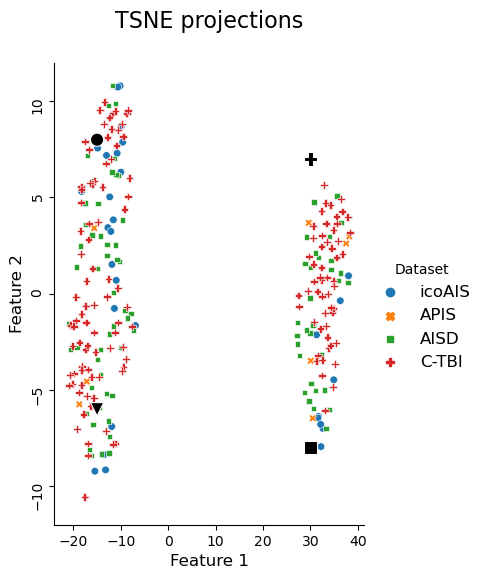

In [19]:
base_cfg_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2/ssl/cfg_files/ssl_pretrain/')
base_experiments_path = Path('/home/jseia/Desktop/thesis/experiments/')

%matplotlib inline
exps_cfgs = [
    {'data': 'all_ncct', 'exp': '004', 'context': 'sym', 'encoder_name': 'SSL-ALL-SA encoder',
     'centers': {'tsne': [[-15, 8], [-15, -6], [30, -8], [30, 7]]}},
]

preproc = False
lims = [-5, 4] if preproc else [0, 80]
gt_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2/preprocessed/Dataset051_AIS/gt_segmentations')
scatter_examples_method_sr(
    base_cfg_path, base_experiments_path, exps_cfgs, gt_path,
    preproc, lims, 'tsne', slice_criteria='middle'
)